МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

In [234]:
from IPython.display import Image
from IPython.core.display import HTML 

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

<Ответ>

> Объект -- пара (документ, запрос)
> Целевые метки -- оценка релевантности пар запрос-документ.
Т.е. это некое упорядочивание по релевантности определенному запросу некоторого множества документов.
> Между собой сравнимы пары (запрос-документ)

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

<Ответ>

> Метрика MAP не учитывает ранг документа, а просто учитывает, релевантен он или нет.
NDCG учитывает ранг документа.



**3.** Почему говорят, что все основные метрики качества дискретны?

<Ответ>

> Потому что почти в каждой используется сумма по функциям от дискретных значений.

**4.** В чем преимущество факторизации в модели RankNet?

<Ответ>

> Благодаря факторизации мы сильно упрощаем себе процесс градиентного спуска.

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

<Ответ>

> В этим моделях важны не сами метрики, а их производные. Потому там просто подбираются нужные производные, по которым, вообще говоря можно восстановить и саму функцию.


**6.** Какое преобразование данных используется в модели RankSVM?

<Ответ>

> $(X_k, Y_k) = (X_i - X_j, sign(Y_i-Y_j))$ для пар, для которых можно определить порядок.

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

<Ответ>


**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

<Ответ>
> С точки зрения теории не очень важно, какое там было начальное распределение. Хорошо, конечно, если в нем все числа были положительными.

# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

<Решения>

## Часть 1

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline
plt.style.use('ggplot')

# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)
# plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
# plt.rc('font', family='serif', size='16')

Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [2]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    
    ''' По веб-графу со списком ребер links строит матрицу 
        переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''
    
    def get_prob_ij(i, j, graph, p, V):
        """
        V -- множество вершин; 
        
        """
    
        neighbors = graph.neighbors(i)
        N = len(neighbors)
        if N == 0:
            return 1./V
        else:
            return (1-p)/N*int(j in neighbors)+p*1./V 
            
    def make_graph(links, N):
    
        """
        Making directed graph;
        links --- список (list) пар вершин (tuple), 
        может быть передан в виде numpy.array, shape=(|E|, 2);

        """
        DG = nx.DiGraph()
        DG.add_edges_from(links)
        nodes = DG.nodes()
#         if (N is None):
#             DG.add_nodes_from(range(max(nodes)+1))
            
        if (N is not None) and (max(nodes)+1!=N):
            DG.add_nodes_from(range(N))
#             print(DG.nodes(), len(DG.nodes()))
        else:
            DG.add_nodes_from(range(max(nodes)+1))
            
        return DG

    
    links = np.array(links)
    g = make_graph(links, N)
    
    nodes = g.nodes()
    N = len(nodes)
#     print("N=", N)
    mtx = np.zeros((N, N))
    
    for i in nodes:
        mtx[i] = [get_prob_ij(i, j, g, damping_factor, N) for j in nodes]
    
    return mtx


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False, N = None):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    def __euclideanNorm(series):
        return np.sqrt(series.dot(series.T))
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor, N=N)
    
   
    distribution = np.matrix(start_distribution)
#     print("prob_matrix.shape", prob_matrix.shape)
#     print("max(links):", max(links))
#     print("len(links:)", len(links))
#     print("distribution.shape", distribution.shape)
    
    trace = []
    
    while True:
        distribution = np.matrix(start_distribution)
        start_distribution = distribution.dot(prob_matrix)
        diff = distribution - start_distribution
        
        if return_trace:
            trace.append(start_distribution)
        
        if __euclideanNorm(diff)<=tolerance:
#             print('Converges!')
            break
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
import itertools
def random_graph(n, p):
#     return <Cписок ребер. Сможете в одну строчку? ;)>
    bag_of_edges = [e for e in itertools.product(range(n), range(n)) if e[0]!=e[1]]
    edges = [bag_of_edges[i] for i in range(n*(n-1)) if np.random.choice((0,1), p=((1-p),p)) == 1]
    return edges

Теперь сгенерируем случайный граф и нарисуем его.

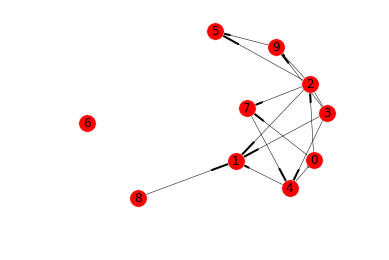

In [4]:
N, p = 10, 0.2
edges = random_graph(N, p)
# G = nx.gnm_random_graph(N, 10, directed=True)

G = networkx.DiGraph()
G.add_edges_from(edges)
G.add_nodes_from(range(N))
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

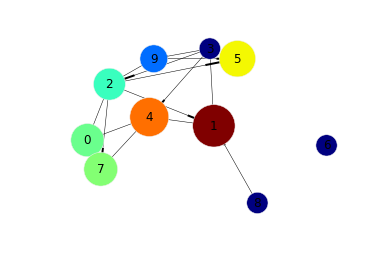

In [5]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution, N = N)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

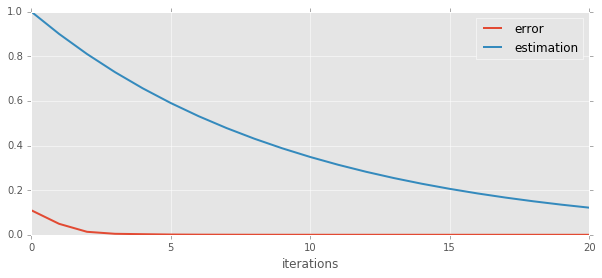

In [6]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True, N=N)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
epsilon = np.min(start_distribution)
plt.plot(x, [(1-epsilon)**n for n in range(len(pr_trace))] ,lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

<Выводы>

>Верхняя оценка является все же весьма приближенной, но она вполне описывает характер убывания ошибки с ростом n.

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

<Исследования и выводы>

## Исследование зависимости [количества итераций до сходимости] от p, n, density

In [7]:
def graph_density(N, links):
    """
    здесь N -- количество вершин в графе
    links -- количество связей в графе
    """
    return len(links)/(N*(N-1))

In [8]:
from tqdm import tqdm
def exploration(n_array, p_array):
    
    ##### creating graph #####
    
    n_iters = {}
    p_iters = {}
    density = {}
    
    for n in tqdm(n_array):
        edges = random_graph(n, p_array[0])
        start_distribution = np.ones((1, n)) / n
        pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True, N=n)
        n_iters[n] = len(pr_trace)
        density[graph_density(n, edges)] = len(pr_trace)
    
    start_distribution = np.ones((1, n_array[0])) / n_array[0]
    for p in tqdm(p_array):
        
        edges = random_graph(n_array[0], p)
        pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True, N=n_array[0])
        p_iters[p] = len(pr_trace)
        
        den = graph_density(n_array[0], edges)
        if den not in density.keys():
            density[den] = len(pr_trace)
        else:
            density[den] = np.max((density[den], len(pr_trace)))
            print("swap or not before{} after{}".format(density[den], len(pr_trace)))

    plt.figure(figsize=(10, 4))
    plt.scatter(list(n_iters.keys()), list(n_iters.values()), label = 'n_dependancy')
    plt.xlabel("number of nodes")
    plt.ylabel("number of steps to converge")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.scatter(list(p_iters.keys()), list(p_iters.values()), label='p_dependancy', c='r')
    plt.ylabel("number of steps to converge")
    plt.xlabel("probability to connect two vertices")
    
    plt.figure(figsize=(10, 4))
    plt.scatter(list(density.keys()), list(density.values()), label='density_dependancy', c='g')
    plt.ylabel("number of steps to converge")
    plt.xlabel("graph density")

    plt.legend()
    plt.show()


100%|██████████| 20/20 [00:00<00:00, 205.92it/s]


swap or not before23 after23
swap or not before12 after12
swap or not before9 after9


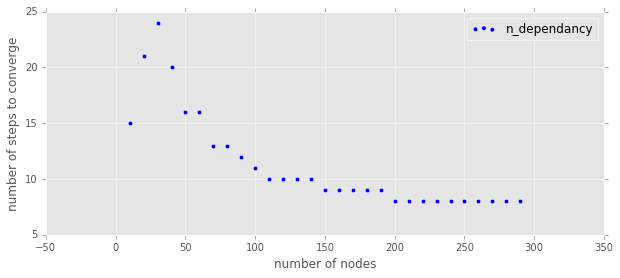

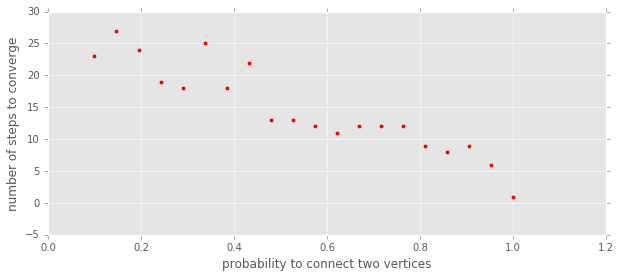

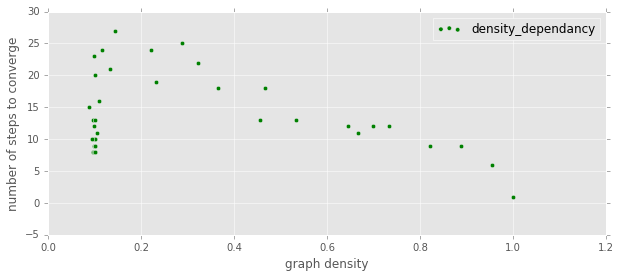

In [229]:
exploration(n_array=list(range(10,300,10)), p_array=np.linspace(0.1,1,num=20))

**Вывод:**

Чем больше нод в графе, тем лучше сходится метод -- т.е тем меньше итераций необходимо для его сходимости.

Что насчет $p$ -- сходимость метода тем быстрее, чем больше вероятность $p$.
Возникает гипотеза, что чем более плотным является граф, тем лучше сходится метод.
Поэтому был построен самый нижний график.
Но момент, когда количество шагов для сходимости начинает убывать наступает не сразу.
В начале наблюдается некое резкое повышение необходимого числа итераций.
Таким образом гипотеза оказывается верной, но только начиная с плотности графа больше 0.3.

Можно только сказать, что чем больше вершин в графе, и чем больше они связаны между собой, тем меньше итераций нужно для сходимости метода.

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [9]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [77]:
urls = ['https://github.com/dennybritz']
site = get_site(urls[0])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

In [80]:
def drop_links(urls, links, N):
    links_new = [k for k in links if k[1]<=N]
    urls_new = urls[:N]
    return urls_new, links_new

In [48]:
urls, links = drop_links(urls, links, 1000)

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

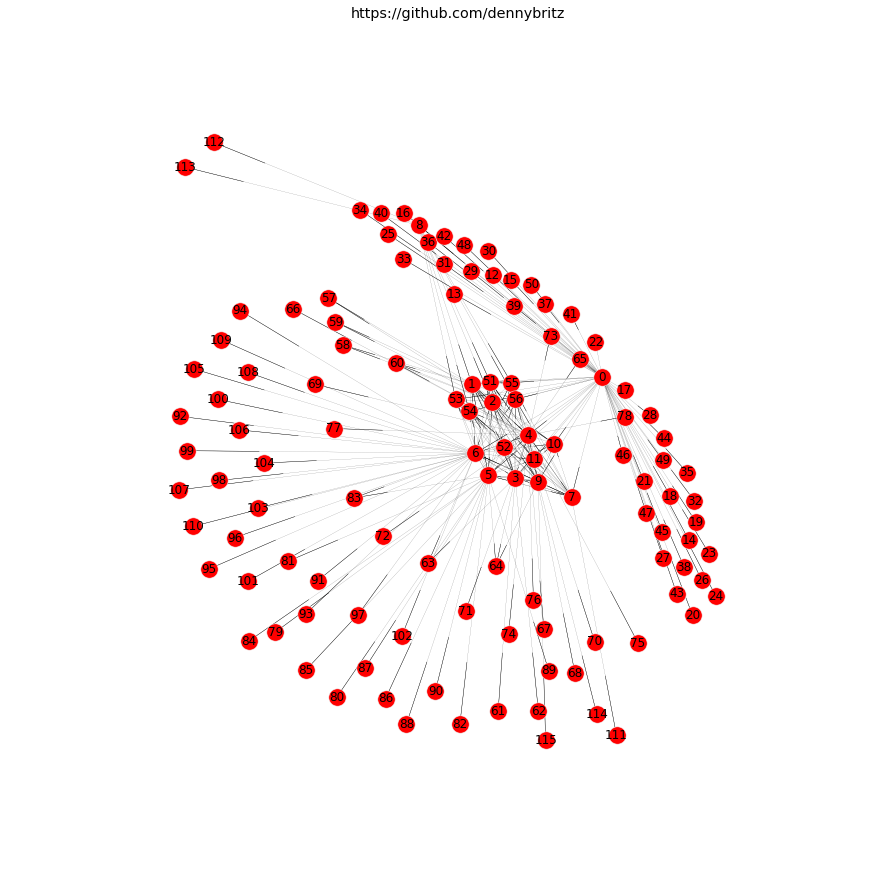

In [81]:
G = nx.DiGraph()
G.add_edges_from(links)
plt.figure(figsize=(15,15))
plt.axis('off')
nx.draw_networkx(G, width=0.1, node_size=300)
plt.title("https://github.com/dennybritz")

In [61]:
urls[39]

'https://github.com/site/privacy'

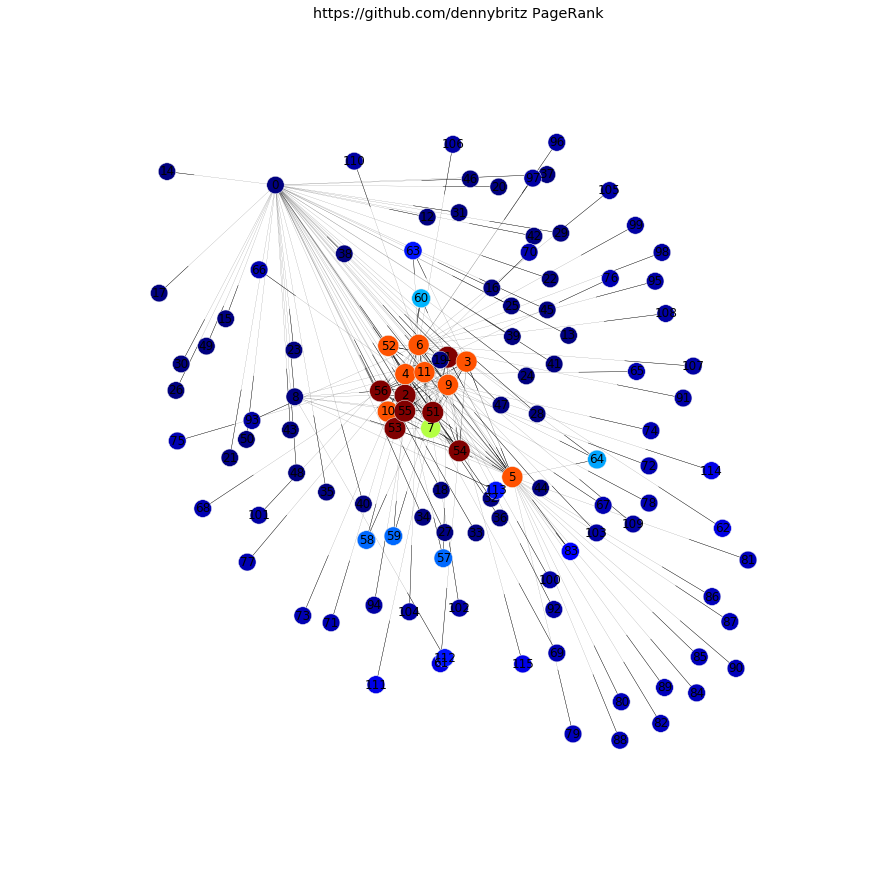

In [82]:
N = np.max(links)+1
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(links, start_distribution, N = N)

size_const = 14 ** 4

plt.figure(figsize=(15,15))
plt.axis('off')
plt.title("https://github.com/dennybritz PageRank")
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Самые яркие страницы Денни:

(понятно, это страницы, которые есть в футере и заголовке почти каждой страницы)

In [83]:
for i in [1,2,51,53,54,55,56,]:
    print(urls[i])

https://github.com#start-of-content
https://github.com/
https://github.com/contact
https://github.com
https://github.com/site/terms
https://github.com/site/privacy
https://github.com/security


## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [236]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[1:-1])), 
                                         text[index:index + num_lines])))
        values.append(block_values)
        text = text[index:]
        
    return values

In [138]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[-1].strip()))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:-2]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)


def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')
            

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

In [139]:
relevs, qids, features = read_file('./imat2009-datasets/imat2009_learning.txt', 250)

/home/fogside/virtualenv/python3/lib/python3.4/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [143]:
split_to_train_valid_test(relevs, qids, features,
                          './data/train.txt', './data/test.txt', 0.1, 0.1, 
                          valid_path='./data/valid.txt', valid_size=0.1)

Обучаем на `train` методы `MART` и `LambdaMART` на 300 итераций, указав им метрику `NDCG` и передав так же `valid.`

In [156]:
### LambdaMART ###

%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -tree 300 -leaf 5 -kcv 3 -metric2t NDCG@10 -save ./model/LambdaMART_300_5.txt > ./model/log_LambdaMART_300_5.txt

CPU times: user 1.7 s, sys: 184 ms, total: 1.88 s
Wall time: 1min 27s


In [157]:
### MART ###

%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 0 -tree 300 -leaf 5 -kcv 3 -metric2t NDCG@10 -save ./model/MART_300_5.txt > ./model/log_MART_300_5.txt

CPU times: user 1.46 s, sys: 144 ms, total: 1.61 s
Wall time: 1min 16s


In [144]:
! java -jar RankLib.jar

Usage: java -jar RankLib.jar <Params>
Params:
  [+] Training (+ tuning and evaluation)
	-train <file>		Training data
	-ranker <type>		Specify which ranking algorithm to use
				0: MART (gradient boosted regression tree)
				1: RankNet
				2: RankBoost
				3: AdaRank
				4: Coordinate Ascent
				6: LambdaMART
				7: ListNet
				8: Random Forests
				9: Linear regression (L2 regularization)
	[ -feature <file> ]	Feature description file: list features to be considered by the learner, each on a separate line
				If not specified, all features will be used.
	[ -metric2t <metric> ]	Metric to optimize on the training data. Supported: MAP, NDCG@k, DCG@k, P@k, RR@k, ERR@k (default=ERR@10)
	[ -gmax <label> ]	Highest judged relevance label. It affects the calculation of ERR (default=4, i.e. 5-point scale {0,1,2,3,4})
	[ -silent ]		Do not print progress messages (which are printed by default)

	[ -validate <file> ]	Specify if you want to tune your system on the validation data (default=unspecified

In [158]:
### Полученные значения метрики: ###

result_MART = read_metric_dependence_from_file(file_name="./model/log_MART_300_5.txt", num_lines=300, num_blocks=3)

In [162]:
result_LambdaMART = read_metric_dependence_from_file(file_name="./model/log_LambdaMART_300_5.txt", num_lines=300, num_blocks=3)

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

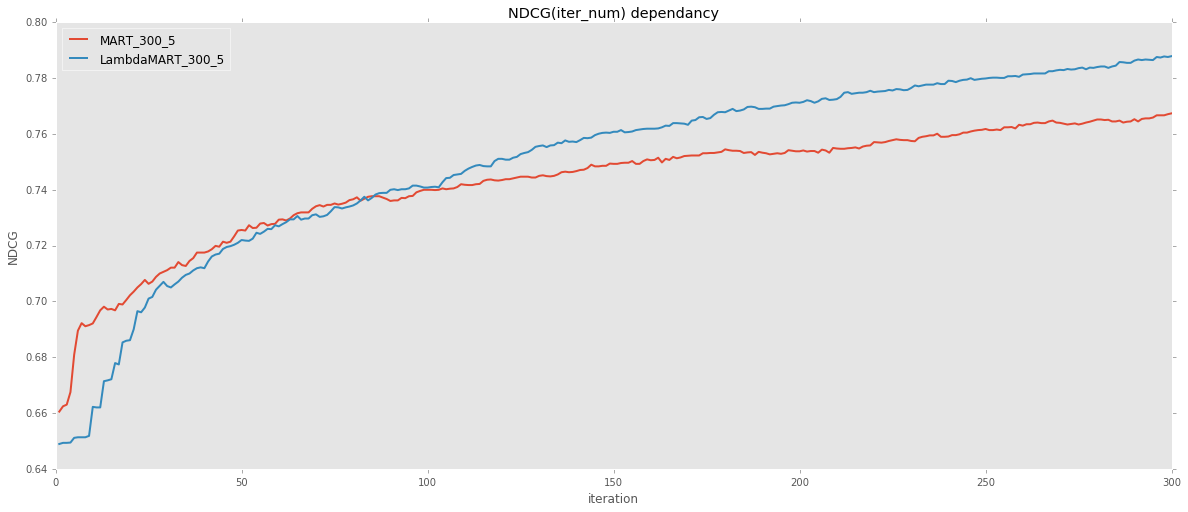

In [174]:
# values = (read_metric_dependence_from_file('... log_LambdaMART', 300)[0],
#           read_metric_dependence_from_file('... log_MART', 300)[0])

plt.figure(figsize=(20, 8))
plt.plot(result_MART[0][:,0], result_MART[0][:,1], lw=2, label="MART_300_5")
plt.plot(result_LambdaMART[0][:,0], result_LambdaMART[0][:,1], lw=2, label="LambdaMART_300_5")

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("NDCG(iter_num) dependancy")
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

<Ответ>

> При переобучении скор на тесте начинает падать, а на трейне расти. 
> Я не вижу здесь точки, где скор на тесте начинает падать. Т.е. я считаю, что модель не переобучается.
>
> До 100 итераций модели не сильно отличаются по качеству, но уже дальше LambdaMART заметно обгоняет модель MART.
>



Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

### RankNet ###

In [177]:
%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -metric2t NDCG@10 -save ./model/RankNet.txt > ./model/log_RankNet.txt

CPU times: user 2.35 s, sys: 192 ms, total: 2.54 s
Wall time: 2min 3s


In [178]:
%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -layer 3 -node 30 -metric2t NDCG@10 -save ./model/RankNet_3_30.txt > ./model/log_RankNet_3_30.txt

CPU times: user 4.06 s, sys: 380 ms, total: 4.44 s
Wall time: 8min 27s


In [185]:
result_RankNet_default = read_metric_dependence_from_file(file_name="./model/log_RankNet.txt", num_lines=100, num_blocks=1)
result_RankNet_3_30 = read_metric_dependence_from_file(file_name="./model/log_RankNet_3_30.txt", num_lines=100, num_blocks=1)

In [225]:
rank_val = [result_RankNet_default[0][1:][i][-1] for i in range(0,99)]

In [227]:
rank_val_3_30 = [result_RankNet_3_30[0][1:][i][-1] for i in range(0,99)]

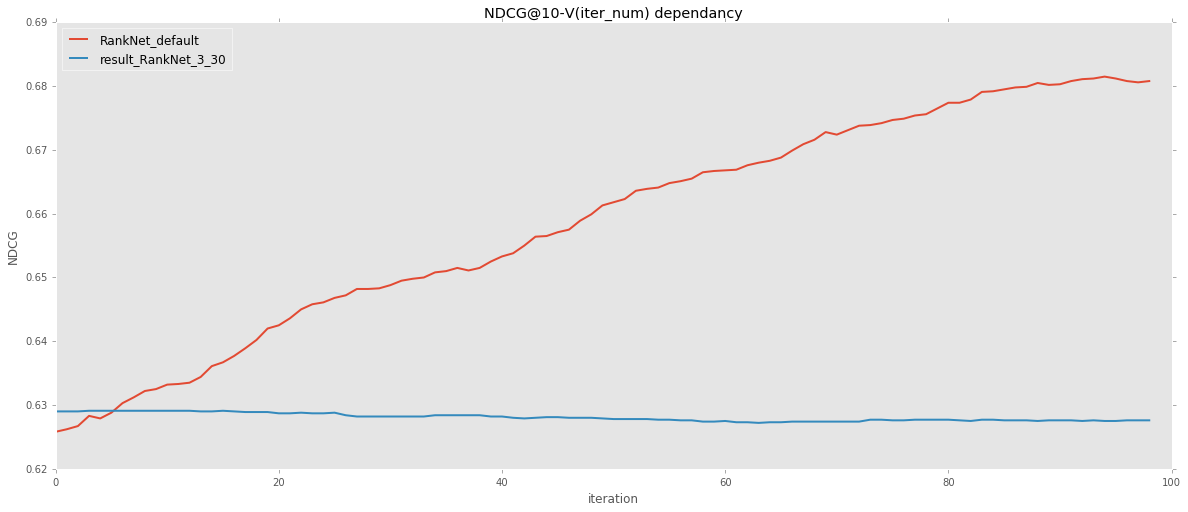

In [229]:
plt.figure(figsize=(20, 8))
plt.plot(range(0,99), rank_val, lw=2, label="RankNet_default")
plt.plot(range(0,99), rank_val_3_30, lw=2, label="result_RankNet_3_30")

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("NDCG@10-V(iter_num) dependancy")
plt.legend(loc=2)
plt.grid()
plt.show()

In [230]:
rank_val_1 = [result_RankNet_default[0][1:][i][-2] for i in range(0,99)]
rank_val_3_30_1 = [result_RankNet_3_30[0][1:][i][-2] for i in range(0,99)]

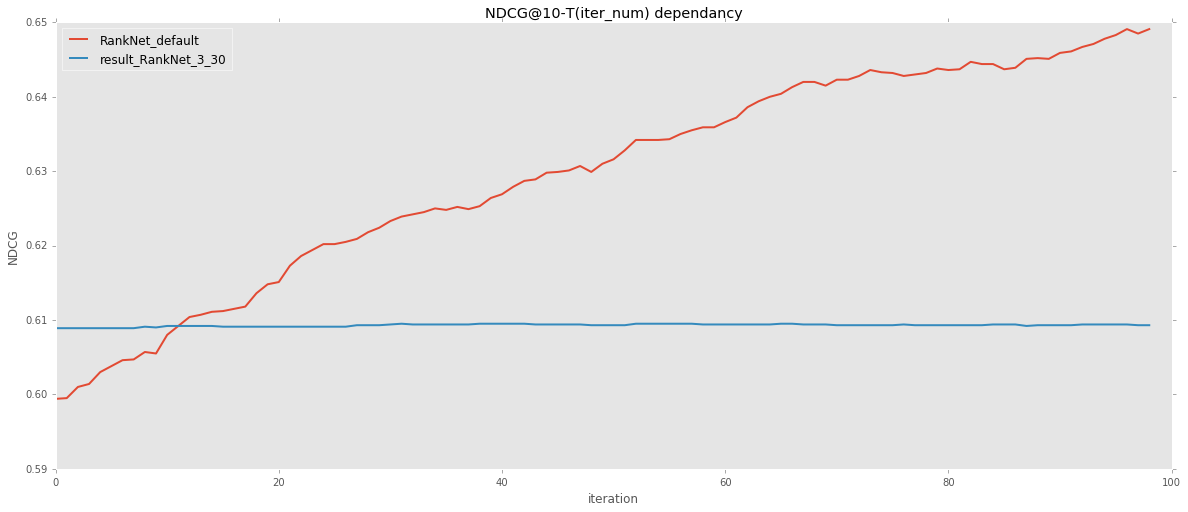

In [231]:
plt.figure(figsize=(20, 8))
plt.plot(range(0,99), rank_val_1, lw=2, label="RankNet_default")
plt.plot(range(0,99), rank_val_3_30_1, lw=2, label="result_RankNet_3_30")

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("NDCG@10-T(iter_num) dependancy")
plt.legend(loc=2)
plt.grid()
plt.show()

### RandomForest ###

In [260]:
%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 8 -tree 300 -bag 100 -metric2t NDCG@10 -save ./model/RF.txt > ./model/log_RF.txt

^C
CPU times: user 25.1 s, sys: 2.36 s, total: 27.5 s
Wall time: 22min 29s


In [261]:
%%time
! java -jar RankLib.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 8 -tree 400 -bag 100 -metric2t NDCG@10 -srate 0.7 -save ./model/RF_ss.txt > ./model/log_RF_ss.txt

^C
CPU times: user 40 ms, sys: 24 ms, total: 64 ms
Wall time: 2.4 s


In [255]:
result_RF_default = read_metric_dependence_from_file(file_name="./model/log_RF.txt", num_lines=300, num_blocks=1)
result_RF_ss = read_metric_dependence_from_file(file_name="./model/log_RF_ss.txt", num_lines=300, num_blocks=1)

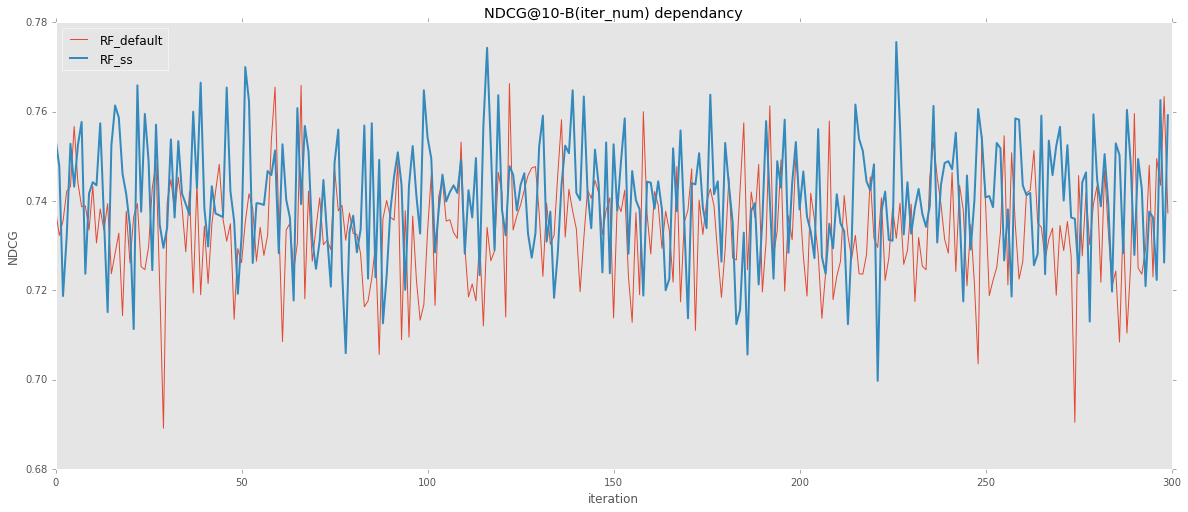

In [257]:
plt.figure(figsize=(20, 8))
plt.plot(range(0,300), np.array(result_RF_default[0]).flatten(), label="RF_default_300")
plt.plot(range(0,300), np.array(result_RF_ss[0]).flatten(), lw=2, label="RF_ss_400")

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title("NDCG@10-B(iter_num) dependancy")
plt.legend(loc=2)
plt.grid()
plt.show()

Тут результат получен кажется для одного обученного дерева. Поэтому выглядит грустно.
Но для 300 деревьев оно слишком долго считало.

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ>

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [ ]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

Если код выше не работает, воспользуйтесь следующей функцией.

In [ ]:
import subprocess

def _run_cmd(cmd, print=False):
    """ Запуск консольной команды cmd """
    
    PIPE = subprocess.PIPE
    p = subprocess.Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE,
                         stderr=subprocess.STDOUT, close_fds=True)
    output = ''
    
    while True:
        s = p.stdout.readline().decode('utf-8')
        if not s: break
        output += str(s)
        if print:
            print(s)
    
    return output